# Recurrent Neural Networks

## Univariate Time Series Regression

This notebook demonstrates how to forecast the S&P 500 index using a Recurrent Neural Network.

## Imports & Settings

In [62]:
import warnings
warnings.filterwarnings('ignore')

In [63]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
sns.set_style('whitegrid')
np.random.seed(42)

In [5]:
results_path = Path('results', 'univariate_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Get Data

We obtain data for 2010-2018 from the Federal Reserve Bank’s Data Service [FRED](https://fred.stlouisfed.org/) using the [pandas_datareader](https://pandas-datareader.readthedocs.io/) library in introduced in [Chapter 2 on Market and Fundamental Data](../02_market_and_fundamental_data).

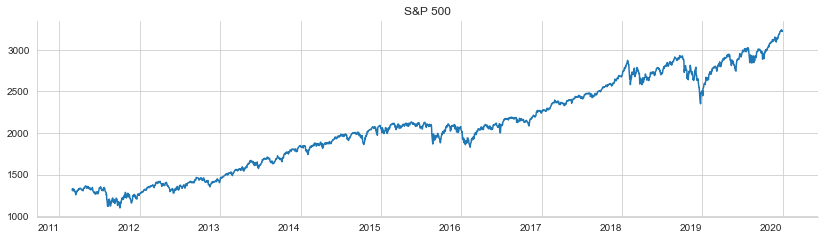

In [12]:
sp500 = web.DataReader('SP500', 'fred', start='2010', end='2020').dropna()
ax = sp500.plot(title='S&P 500',
           legend=False,
           figsize=(14, 4),
           rot=0)
ax.set_xlabel('')
sns.despine()

In [13]:
sp500

,SP500
DATE,
2011-02-28,1327.22
2011-03-01,1306.33
2011-03-02,1308.44
2011-03-03,1330.97
2011-03-04,1321.15
...,...
2019-12-24,3223.38
2019-12-26,3239.91
2019-12-27,3240.02


In [14]:
sp500_return = np.log(sp500/sp500.shift()).fillna(0)

In [15]:
sp500_return

,SP500
DATE,
2011-02-28,0.000000
2011-03-01,-0.015865
2011-03-02,0.001614
2011-03-03,0.017072
2011-03-04,-0.007405
...,...
2019-12-24,-0.000195
2019-12-26,0.005115
2019-12-27,0.000034


## Preprocessing

In [16]:
scaler = MinMaxScaler()

In [17]:
sp500_return_scaled = pd.Series(scaler.fit_transform(sp500_return).squeeze(), 
                         index=sp500_return.index)
sp500_return_scaled.describe()

count    2226.000000
mean        0.590977
std         0.077502
min         0.000000
25%         0.559979
50%         0.592211
75%         0.629894
max         1.000000
dtype: float64

## Generating recurrent sequences from our time series

Our time series is a sequence of numbers indexed by time:

$$x_{0},x_{1},x_{2},...,x_{T}$$

where $\{x_t\}$ is the numerical value in period $t$ and  $T$ is the total length of the series. 

To apply a RNN for regression of classification, we use a sliding window to construct a rolling set of input/output pairs for our model to learn from as animated below.

We will generate sequences of 63 trading days, approximately three months, and use a single LSTM layer with 20 hidden units to predict the index value one timestep ahead. 
The input to every LSTM layer must have three dimensions, namely:
- **Samples**: One sequence is one sample. A batch contains one or more samples.
- **Time Steps**: One time step is one point of observation in the sample.
- **Features**: One feature is one observation at a time step.

Our S&P 500 sample has 2,264 observations or time steps. We will create overlapping sequences using a window of 63 observations each.
For a simpler window of size T = 5, we obtain input-output pairs as shown in the following table:

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline  {\langle x_1,x_2,x_3,x_4,x_5\rangle} & { x_6} \\
\ {\langle x_{2},x_{3},x_{4},x_{5},x_{6} \rangle } & {x_{7} } \\
  {\vdots} & {\vdots}\\
 { \langle x_{T-5},x_{T-4},x_{T-3},x_{T-2},x_{T-1} \rangle } &  {x_{T}}
\end{array}$$

Generally speaking, for window size S, the relationship takes the form 

$$x_t = f( x_{t-1}, x_{t-2}, ..., x_{t-S}) \quad\forall t=S, S+1, ..., T$$

Each of the $T-S$ lagged input sequence or vector is of length S with a corresponding scalar output.

We can use the function create_univariate_rnn_data() to stack sequences selected using a rolling windows:

In [20]:
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

We apply this function to the rescaled stock index for a window_size=63 to obtain a two-dimensional dataset of shape number of samples x number of timesteps:

In [21]:
window_size = 63

In [23]:
X, y = create_univariate_rnn_data(sp500_return_scaled, window_size=window_size)

In [24]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
DATE,,,,,,,,,,,,,,,,,,,,,
2011-05-27,0.587572,0.452392,0.601323,0.733040,0.524472,0.516201,0.663263,0.575961,0.425242,0.647690,...,0.518554,0.534542,0.584431,0.662257,0.606109,0.521809,0.485347,0.580519,0.614652,0.621189
2011-05-31,0.452392,0.601323,0.733040,0.524472,0.516201,0.663263,0.575961,0.425242,0.647690,0.535871,...,0.534542,0.584431,0.662257,0.606109,0.521809,0.485347,0.580519,0.614652,0.621189,0.622273
2011-06-01,0.601323,0.733040,0.524472,0.516201,0.663263,0.575961,0.425242,0.647690,0.535871,0.491599,...,0.584431,0.662257,0.606109,0.521809,0.485347,0.580519,0.614652,0.621189,0.622273,0.677354
2011-06-02,0.733040,0.524472,0.516201,0.663263,0.575961,0.425242,0.647690,0.535871,0.491599,0.419821,...,0.662257,0.606109,0.521809,0.485347,0.580519,0.614652,0.621189,0.622273,0.677354,0.391185
2011-06-03,0.524472,0.516201,0.663263,0.575961,0.425242,0.647690,0.535871,0.491599,0.419821,0.700976,...,0.606109,0.521809,0.485347,0.580519,0.614652,0.621189,0.622273,0.677354,0.391185,0.577130


In [25]:
y.head()

DATE
2011-05-27    0.622273
2011-05-31    0.677354
2011-06-01    0.391185
2011-06-02    0.577130
2011-06-03    0.504226
dtype: float64

In [26]:
X.shape

(2163, 63)

## Train-test split

To respect the time series nature of the data, we set aside the data at the end of the sample as hold-out or test set. More specifically, we'll use the data for 2018.

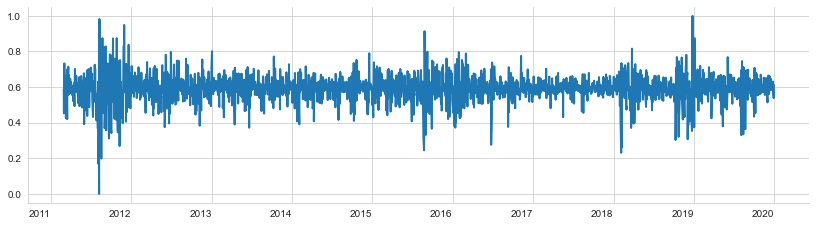

In [27]:
ax = sp500_return_scaled.plot(lw=2, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [28]:
X_train = X[:'2018'].values.reshape(-1, window_size, 1)
y_train = y[:'2018']

# keep the last year for testing
X_test = X['2019'].values.reshape(-1, window_size, 1)
y_test = y['2019']

In [29]:
n_obs, window_size, n_features = X_train.shape

In [30]:
y_train.shape

(1911,)

## Keras LSTM Layer

Keras has several built-in RNN layers with various configuration options described in detail in the [documentation](https://keras.io/layers/recurrent/).

```
LSTM(units,
     activation='tanh',
     recurrent_activation='hard_sigmoid',
     use_bias=True,
     kernel_initializer='glorot_uniform',
     recurrent_initializer='orthogonal',
     bias_initializer='zeros',
     unit_forget_bias=True,
     kernel_regularizer=None,
     recurrent_regularizer=None,
     bias_regularizer=None,
     activity_regularizer=None,
     kernel_constraint=None,
     recurrent_constraint=None,
     bias_constraint=None,
     dropout=0.0,
     recurrent_dropout=0.0,
     implementation=1,
     return_sequences=False,
     return_state=False,
     go_backwards=False,
     stateful=False,
     unroll=False)
 ```

##  Define the Model Architecture

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 20 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used (remember: we are performing regression here)

This can be constructed using just a few lines - see e.g., the [general Keras documentation](https://keras.io/getting-started/sequential-model-guide/) and the [LSTM documentation in particular](https://keras.io/layers/recurrent/) for examples of how to quickly use Keras to build neural network models.  Make sure you are initializing your optimizer given the [keras-recommended approach for RNNs](https://keras.io/optimizers/) 

In [31]:
rnn = Sequential([
    LSTM(units=10, 
         input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

The summary shows that the model has 1,781 parameters:

In [32]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 10)                480       
_________________________________________________________________
Output (Dense)               (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


## Train the Model

We train the model using the RMSProp optimizer recommended for RNN with default settings and compile the model with mean squared error for this regression problem:

In [33]:
optimizer = keras.optimizers.RMSprop(lr=0.001,
                                     rho=0.9,
                                     epsilon=1e-08,
                                     decay=0.0)

In [34]:
rnn.compile(loss='mean_squared_error', 
            optimizer=optimizer)

We define an EarlyStopping callback and train the model for up to 100 episodes. 

In [35]:
rnn_path = (results_path / 'rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=20,
                              restore_best_weights=True)

In [37]:
lstm_training = rnn.fit(X_train,
                        y_train,
                        epochs=150,
                        batch_size=20,
                        shuffle=True,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping, checkpointer],
                        verbose=1)

Epoch 1/150
96/96 [==============================] - 4s 14ms/step - loss: 0.1637 - val_loss: 0.0050

Epoch 00001: val_loss improved from inf to 0.00498, saving model to results/univariate_time_series\rnn.h5
Epoch 2/150
96/96 [==============================] - 1s 9ms/step - loss: 0.0077 - val_loss: 0.0053

Epoch 00002: val_loss did not improve from 0.00498
Epoch 3/150
96/96 [==============================] - 1s 9ms/step - loss: 0.0069 - val_loss: 0.0055

Epoch 00003: val_loss did not improve from 0.00498
Epoch 4/150
96/96 [==============================] - 1s 9ms/step - loss: 0.0067 - val_loss: 0.0050

Epoch 00004: val_loss did not improve from 0.00498
Epoch 5/150
96/96 [==============================] - 1s 9ms/step - loss: 0.0070 - val_loss: 0.0045

Epoch 00005: val_loss improved from 0.00498 to 0.00454, saving model to results/univariate_time_series\rnn.h5
Epoch 6/150
96/96 [==============================] - 1s 9ms/step - loss: 0.0070 - val_loss: 0.0050

Epoch 00006: val_loss did not 

96/96 [==============================] - 1s 8ms/step - loss: 0.0059 - val_loss: 0.0045

Epoch 00051: val_loss did not improve from 0.00445
Epoch 52/150
96/96 [==============================] - 1s 9ms/step - loss: 0.0060 - val_loss: 0.0046

Epoch 00052: val_loss did not improve from 0.00445
Epoch 53/150
96/96 [==============================] - 1s 8ms/step - loss: 0.0065 - val_loss: 0.0045

Epoch 00053: val_loss did not improve from 0.00445
Epoch 54/150
96/96 [==============================] - 1s 9ms/step - loss: 0.0063 - val_loss: 0.0049

Epoch 00054: val_loss did not improve from 0.00445
Epoch 55/150
96/96 [==============================] - 1s 8ms/step - loss: 0.0065 - val_loss: 0.0045

Epoch 00055: val_loss did not improve from 0.00445
Epoch 56/150
96/96 [==============================] - 1s 9ms/step - loss: 0.0063 - val_loss: 0.0045

Epoch 00056: val_loss did not improve from 0.00445
Epoch 57/150
96/96 [==============================] - 1s 8ms/step - loss: 0.0065 - val_loss: 0.0046



Training stops after 51 epochs; the `early_stopping` callback restores the weights for the best model (after 41 epochs)

## Evaluate model performance

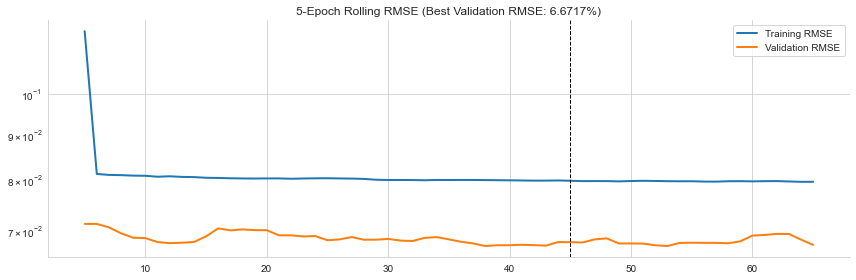

In [38]:
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_sp500_error', dpi=300);

In [39]:
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0792 | Test RMSE: 0.0667


In [40]:
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

In [41]:
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

Train IC: 0.0316 | Test IC: 0.0775


### Rescale predictions

In [42]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled) .squeeze(), index=y_test.index))

In [43]:
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

In [44]:
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'

'Train RMSE: 0.01 | Test RMSE: 0.01'

In [47]:
sp500_return['Train Predictions'] = train_predict
sp500_return['Test Predictions'] = test_predict
sp500_return = sp500_return.join(train_predict.to_frame('predictions').assign(data='Train')
                        .append(test_predict.to_frame('predictions').assign(data='Test')))

In [51]:
pd.set_option('display.max_rows',None)
sp500_return

,SP500,Train Predictions,Test Predictions,predictions,data
DATE,,,,,
2011-02-28,0.000000,NaN,NaN,NaN,NaN
2011-03-01,-0.015865,NaN,NaN,NaN,NaN
2011-03-02,0.001614,NaN,NaN,NaN,NaN
2011-03-03,0.017072,NaN,NaN,NaN,NaN
2011-03-04,-0.007405,NaN,NaN,NaN,NaN
2011-03-07,-0.008376,NaN,NaN,NaN,NaN
2011-03-08,0.008883,NaN,NaN,NaN,NaN
2011-03-09,-0.001363,NaN,NaN,NaN,NaN
2011-03-10,-0.019051,NaN,NaN,NaN,NaN


### Plot Results

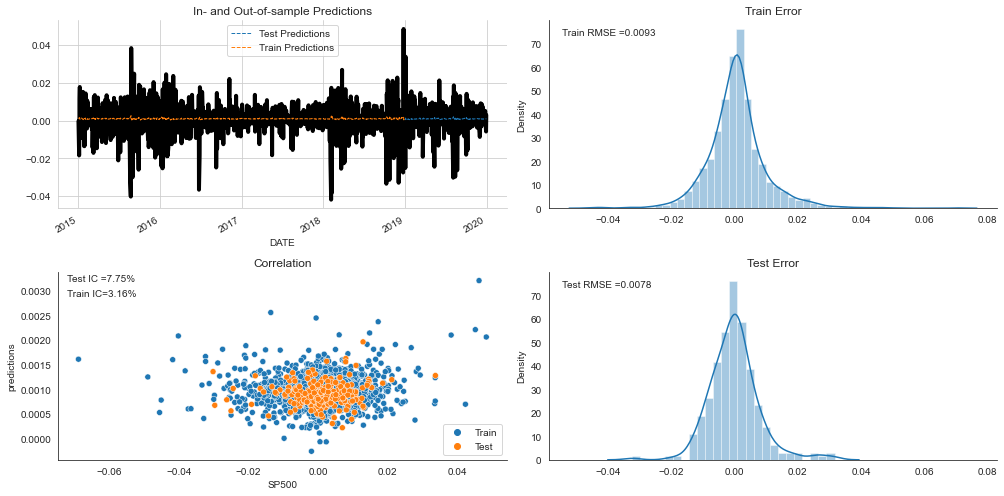

In [52]:
fig=plt.figure(figsize=(14,7))
ax1 = plt.subplot(221)

sp500_return.loc['2015':, 'SP500'].plot(lw=4, ax=ax1, c='k')
sp500_return.loc['2015':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')


with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='SP500', y='predictions', data=sp500_return, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
# fig.savefig(results_path / 'rnn_sp500_regression', dpi=300);

In [53]:
sp500_return

,SP500,Train Predictions,Test Predictions,predictions,data
DATE,,,,,
2011-02-28,0.000000,NaN,NaN,NaN,NaN
2011-03-01,-0.015865,NaN,NaN,NaN,NaN
2011-03-02,0.001614,NaN,NaN,NaN,NaN
2011-03-03,0.017072,NaN,NaN,NaN,NaN
2011-03-04,-0.007405,NaN,NaN,NaN,NaN
2011-03-07,-0.008376,NaN,NaN,NaN,NaN
2011-03-08,0.008883,NaN,NaN,NaN,NaN
2011-03-09,-0.001363,NaN,NaN,NaN,NaN
2011-03-10,-0.019051,NaN,NaN,NaN,NaN


In [55]:
test = sp500_return.copy().fillna(0)

In [59]:
k = test['SP500']*test['predictions'][-200:]

In [60]:
k

DATE
2011-02-28             NaN
2011-03-01             NaN
2011-03-02             NaN
2011-03-03             NaN
2011-03-04             NaN
2011-03-07             NaN
2011-03-08             NaN
2011-03-09             NaN
2011-03-10             NaN
2011-03-11             NaN
2011-03-14             NaN
2011-03-15             NaN
2011-03-16             NaN
2011-03-17             NaN
2011-03-18             NaN
2011-03-21             NaN
2011-03-22             NaN
2011-03-23             NaN
2011-03-24             NaN
2011-03-25             NaN
2011-03-28             NaN
2011-03-29             NaN
2011-03-30             NaN
2011-03-31             NaN
2011-04-01             NaN
2011-04-04             NaN
2011-04-05             NaN
2011-04-06             NaN
2011-04-07             NaN
2011-04-08             NaN
2011-04-11             NaN
2011-04-12             NaN
2011-04-13             NaN
2011-04-14             NaN
2011-04-15             NaN
2011-04-18             NaN
2011-04-19             

In [61]:
len(k[k>0])

117